<a href="https://colab.research.google.com/github/JesseTNRoberts/AAAI-paper-2024/blob/main/pop_analysis_dropout_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nbformat --upgrade
!pip install seaborn
!pip install researchpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 958.8 kB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.1
    Uninstalling nbformat-5.9.1:
      Successfully uninstalled nbformat-5.9.1


In [ ]:
# Assuming your CSV file is named "data.csv"
import pandas as pd
import tqdm

import pandas as pd
import plotly.graph_objects as go
import researchpy as rp
import numpy as np
import ast

from google.colab import drive
drive.mount('/content/drive')

loc = "/content/drive/MyDrive/Data/results/rosch1975_alternate_popLM_50/"

Mounted at /content/drive


In [ ]:
models = ['gpt2_dropout_0.1', 'gpt2_dropout_0.2', 'gpt2_dropout_0.3', 'gpt2_dropout_0.4',
          'gpt2_dropout_0.5', 'gpt2_dropout_0.6', 'gpt2_dropout_0.7', 'gpt2_dropout_0.8']

# for sum
#select_reduction = 0
# for mean
select_reduction = 1

full_range = np.arange(0.1,0.9,0.1)
short_range = full_range

temp = pd.read_csv(loc+models[0]+".csv")[['item', 'category', 'rank', 'score (sum, mean, [list)']]
temp[str(short_range[0])] = temp['score (sum, mean, [list)'].apply(ast.literal_eval)
temp[str(short_range[0])] = [[t[select_reduction] for t in m] for m in temp[str(short_range[0])]]
temp = temp.drop(columns=['score (sum, mean, [list)'])

temp = temp.explode(str(short_range[0]))
temp['member id'] = temp.groupby(['item', 'category']).cumcount()+1
temp[str(short_range[0])] = temp[str(short_range[0])].astype('float')

data = temp.copy()

short_range = short_range[1:]

for index, model in enumerate(models[1:]):

  temp = pd.read_csv(loc+model+".csv")
  temp[str(short_range[index])] = temp['score (sum, mean, [list)'].apply(ast.literal_eval)
  temp[str(short_range[index])] = [[t[select_reduction] for t in m] for m in temp[str(short_range[index])]]
  temp = temp.drop(columns=['score (sum, mean, [list)'])

  temp = temp.explode(str(short_range[index]))
  temp['member id'] = temp.groupby(['item', 'category']).cumcount()+1
  temp[str(short_range[index])] = temp[str(short_range[index])].astype('float')

  data = pd.merge(data, temp[['category','item', 'member id', str(short_range[index])]], on=['category','item', 'member id'])


data['temp'] = data.apply(lambda row: [row[str(item)] for item in full_range],
                                axis=1)
data['dropout rate'] = data.apply(lambda row: [item for item in full_range],
                                axis=1)

data = data[['item', 'category', 'rank', 'temp', 'dropout rate', 'member id']]
data = data.explode(['temp', 'dropout rate'])
data['rank'] = data['rank'].astype('float')
data['dropout rate'] = data['dropout rate'].astype('float')
data.rename(columns={'temp' : 'probs'}, inplace=True)
data['probs'] = data['probs'].astype('float')
data



,item,category,rank,probs,dropout rate,member id
0,doll,toy,1.0,-3.177063,0.1,1
0,doll,toy,1.0,-3.240669,0.2,1
0,doll,toy,1.0,-3.715557,0.3,1
0,doll,toy,1.0,-4.991940,0.4,1
0,doll,toy,1.0,-5.382118,0.5,1
...,...,...,...,...,...,...
28249,shoe,weapon,60.0,-6.598507,0.4,50
28249,shoe,weapon,60.0,-5.957870,0.5,50
28249,shoe,weapon,60.0,-9.102918,0.6,50
28249,shoe,weapon,60.0,-9.896996,0.7,50


In [ ]:

rosch_val = 'rank'
#rosch_val = 'rating'

# Mean normalized
data['normalized'] = data.groupby(['item','category', 'dropout rate'])['probs'].transform(lambda x: x/np.mean(x))
data = data.reset_index()
data

,index,item,category,rank,probs,dropout rate,member id,normalized
0,0,doll,toy,1.0,-3.177063,0.1,1,0.967183
1,0,doll,toy,1.0,-3.240669,0.2,1,0.916819
2,0,doll,toy,1.0,-3.715557,0.3,1,0.937242
3,0,doll,toy,1.0,-4.991940,0.4,1,1.001450
4,0,doll,toy,1.0,-5.382118,0.5,1,0.788059
...,...,...,...,...,...,...,...,...
225995,28249,shoe,weapon,60.0,-6.598507,0.4,50,1.230226
225996,28249,shoe,weapon,60.0,-5.957870,0.5,50,0.909769
225997,28249,shoe,weapon,60.0,-9.102918,0.6,50,1.207805
225998,28249,shoe,weapon,60.0,-9.896996,0.7,50,1.253806


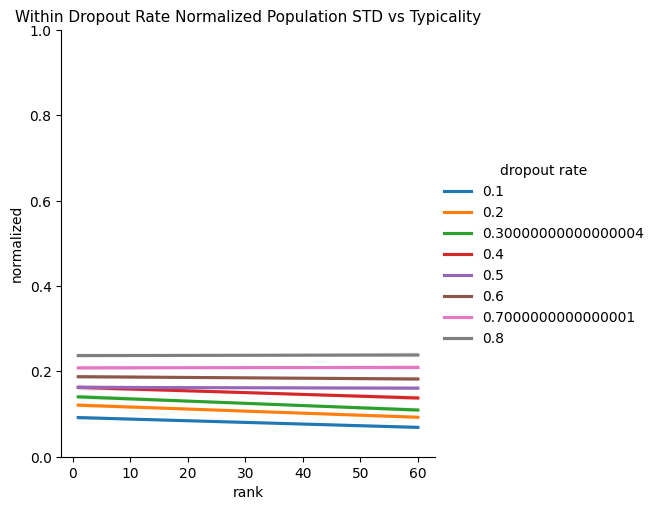

  Spearman Rank correlation test using list-wise deletion
0                     Total observations used = 4520     
             dropout rate normalized    rank
dropout rate          1.0     0.8521     0.0
normalized         0.8521        1.0 -0.0699
rank                  0.0    -0.0699     1.0
             dropout rate normalized    rank
dropout rate       0.0000     0.0000  1.0000
normalized         0.0000     0.0000  0.0000
rank               1.0000     0.0000  0.0000


,item,category,dropout rate,normalized,rank
0,Atom bomb,weapon,0.1,0.094030,13.0
1,Atom bomb,weapon,0.2,0.119364,13.0
2,Atom bomb,weapon,0.3,0.180808,13.0
3,Atom bomb,weapon,0.4,0.219029,13.0
4,Atom bomb,weapon,0.5,0.220629,13.0
...,...,...,...,...,...
4515,yo-yo,toy,0.4,0.174325,5.0
4516,yo-yo,toy,0.5,0.217358,5.0
4517,yo-yo,toy,0.6,0.105104,5.0
4518,yo-yo,toy,0.7,0.205011,5.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


std = data.groupby(['item','category', 'dropout rate']).aggregate({'normalized':np.std})
std['rank'] = data.groupby(['item','category', 'dropout rate'])['rank'].first()
std = std.reset_index()


sns.lmplot(x='rank', y="normalized", data=std, scatter=False, hue='dropout rate')
plt.ylim(0, 1.0)
plt.title( "Within Dropout Rate Normalized Population STD vs Typicality" , size = 11 )
plt.show()


test = 'spearman'

i,r,p = rp.correlation.corr_case(std, method = test)
print(i)
print(r)
print(p)

std

In [ ]:
# How do rank and std correlate as the dropout rate changes?
import researchpy as rp

test = 'pearson'
corr_r_typicality_vs_dropout = []
corr_p_typicality_vs_dropout = []


for item in full_range:
  temp = std[std['dropout rate']==item][['rank', 'normalized']]
  #print(temp)
  i,r,p = rp.correlation.corr_case(temp, method = test)
  print(r,p)
  print('------')
  corr_r_typicality_vs_dropout.append(r['rank'][1])
  corr_p_typicality_vs_dropout.append(p['rank'][1])

plots = []
plots.append(go.Scatter(
    x=full_range,
    y=corr_r_typicality_vs_dropout,
    name= 'coeficient (r)'
  ))

plots.append(go.Scatter(
    x=full_range,
    y=corr_p_typicality_vs_dropout,
    name= 'significance (p)'
  ))

fig1 = go.Figure(plots)
fig1.update_layout(title='correlation (typicality-std probability) vs dropout')
fig1.show(renderer='colab')

              rank normalized
rank           1.0    -0.2624
normalized -0.2624        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.2652
normalized -0.2652        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.2412
normalized -0.2412        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.1861
normalized -0.1861        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.0166
normalized -0.0166        1.0               rank normalized
rank        0.0000     0.6939
normalized  0.6939     0.0000
------
              rank normalized
rank           1.0    -0.0488
norma

In [ ]:
 # How does the correlation of typicality with std change on a per category basis?

test = 'pearson'

this = set(std['category'])

ranks = list(this)
corrs={}
sigs={}


for rank in this:
  group = std[std['category']==rank]
  corrs[rank] = []
  sigs[rank] = []
  for item in full_range:
    i,r,p = rp.correlation.corr_case(group[group['dropout rate']==item][['rank', 'normalized']], method = test)
    print(r,p)
    print('------')
    corrs[rank].append(r['rank'][1])
    sigs[rank].append(p['rank'][1])

avg_corr = [np.mean([corrs[rank][index]
            for rank in ranks])
            for index in range(full_range.shape[0])]

avg_sigs = [np.mean([float(sigs[rank][index])
            for rank in ranks])
            for index in range(full_range.shape[0])]

plots = []
for rank in ranks:
  plots.append(go.Scatter(
    x=full_range,
    y=corrs[rank],
    name= str(rank)
  ))
plots.append(go.Scatter(
    x=full_range,
    y=avg_corr,
    name= 'mean'
  ))

fig = go.Figure(plots)
fig.update_layout(title='correlation (typicality-normalized std) vs dropout (by category)')
fig.show(renderer='colab')


plots = []
for rank in ranks:
  plots.append(go.Scatter(
    x=full_range,
    y=sigs[rank],
    name= str(rank)
  ))
plots.append(go.Scatter(
    x=full_range,
    y=avg_sigs,
    name= 'mean'
  ))

fig1 = go.Figure(plots)
fig1.update_layout(title='significance (typicality-normalized std) vs dropout (by category)',
                   autotypenumbers='convert types')
fig1.show(renderer='colab')

              rank normalized
rank           1.0    -0.5778
normalized -0.5778        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.5567
normalized -0.5567        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.6192
normalized -0.6192        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.5425
normalized -0.5425        1.0               rank normalized
rank        0.0000     0.0000
normalized  0.0000     0.0000
------
              rank normalized
rank           1.0    -0.0848
normalized -0.0848        1.0               rank normalized
rank        0.0000     0.5580
normalized  0.5580     0.0000
------
              rank normalized
rank           1.0    -0.1996
norma

In [ ]:
# How do rank and prob correlate as the dropout rate changes?
import researchpy as rp

test = 'pearson'
corr_r_typicality_vs_dropout = []
corr_p_typicality_vs_dropout = []


for item in full_range:
  print(item)
  temp = data[data['dropout rate']==item][['rank', 'probs']]
  i,r,p = rp.correlation.corr_case(temp, method = test)
  print(r,p)
  print('------')
  corr_r_typicality_vs_dropout.append(r['rank'][1])
  corr_p_typicality_vs_dropout.append(p['rank'][1])

plots = []
plots.append(go.Scatter(
    x=full_range,
    y=corr_r_typicality_vs_dropout,
    name= 'coeficient (r)'
  ))

plots.append(go.Scatter(
    x=full_range,
    y=corr_p_typicality_vs_dropout,
    name= 'significance (p)'
  ))

fig1 = go.Figure(plots)
fig1.update_layout(title='correlation (typicality-probability) vs dropout')
fig1.show(renderer='colab')

0.1
         rank   probs
rank      1.0 -0.1504
probs -0.1504     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
0.2
         rank   probs
rank      1.0 -0.1515
probs -0.1515     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
0.30000000000000004
         rank   probs
rank      1.0 -0.1392
probs -0.1392     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
0.4
         rank   probs
rank      1.0 -0.0945
probs -0.0945     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
0.5
         rank   probs
rank      1.0 -0.0534
probs -0.0534     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
0.6
         rank   probs
rank      1.0 -0.0124
probs -0.0124     1.0          rank   probs
rank   0.0000  0.0370
probs  0.0370  0.0000
------
0.7000000000000001
         rank   probs
rank      1.0 -0.0018
probs -0.0018     1.0          rank   probs
rank   0.0000  0.76

In [ ]:
 # How does the correlation of typicality with prob change on a per category basis?

test = 'pearson'

this = set(data['category'])

ranks = list(this)
corrs={}
sigs={}


for rank in this:
  group = data[data['category']==rank]
  corrs[rank] = []
  sigs[rank] = []
  for item in full_range:
    i,r,p = rp.correlation.corr_case(group[group['dropout rate']==item][['rank', 'probs']], method = test)
    print(r,p)
    print('------')
    corrs[rank].append(r['rank'][1])
    sigs[rank].append(p['rank'][1])

avg_corr = [np.mean([corrs[rank][index]
            for rank in ranks])
            for index in range(full_range.shape[0])]

avg_sigs = [np.mean([float(sigs[rank][index])
            for rank in ranks])
            for index in range(full_range.shape[0])]

plots = []
for rank in ranks:
  plots.append(go.Scatter(
    x=full_range,
    y=corrs[rank],
    name= str(rank)
  ))
plots.append(go.Scatter(
    x=full_range,
    y=avg_corr,
    name= 'mean'
  ))

fig = go.Figure(plots)
fig.update_layout(title='correlation (typicality-probability) vs dropout (by category)')
fig.show(renderer='colab')


plots = []
for rank in ranks:
  plots.append(go.Scatter(
    x=full_range,
    y=sigs[rank],
    name= str(rank)
  ))
plots.append(go.Scatter(
    x=full_range,
    y=avg_sigs,
    name= 'mean'
  ))

fig1 = go.Figure(plots)
fig1.update_layout(title='Significance vs Dropout',
                   autotypenumbers='convert types')
fig1.update_layout(
    xaxis_title="Dropout Rate",
    yaxis_title="Significance",
    font=dict(
        size=14
    ))
fig1.show(renderer='colab')

        rank  probs
rank     1.0 -0.613
probs -0.613    1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
         rank   probs
rank      1.0 -0.5613
probs -0.5613     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
         rank   probs
rank      1.0 -0.4969
probs -0.4969     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
        rank  probs
rank     1.0 -0.271
probs -0.271    1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
         rank   probs
rank      1.0 -0.1068
probs -0.1068     1.0          rank   probs
rank   0.0000  0.0000
probs  0.0000  0.0000
------
         rank   probs
rank      1.0 -0.0258
probs -0.0258     1.0          rank   probs
rank   0.0000  0.1969
probs  0.1969  0.0000
------
         rank   probs
rank      1.0 -0.0354
probs -0.0354     1.0          rank   probs
rank   0.0000  0.0771
probs  0.0771  0.0000
------
         rank   probs
rank      1.0 -0.

This analysis is only relevant for GPT-2.

It is clear that both the normalized prob std correlation and the prob correlation with typicality begin to decorrelate as dropout increases. The evidence suggests that, at dropouts beyond 0.5, all categories decorrelate. Further, as the dropout rate increases, the correlation coeficient begins to drop for all categories.

Thus, the benefit to a large dropout is that it will create separation among natural groups. This comes at a sacrifice as the large dropout (sufficient to create separation) will drive the correlation coefs toward 0. However, we believe large dropout may not be necessary as the separation among the natural groups is captured in the normalized probability std within the natural groups. Thus the best practice here may be to use the previously suggested 0.1 dropout to construct the population. The permits the largest correlation coefs and separation is already visible in the normalized prob std correlation significance.


The categories that are not well correlated with human typicality are shared across models. Plot within category typicality correlation with normalized prob std against average term frequency and the term category word frequency. Look to see if there is a pattern between typicality correlation or significance and training corpus frequency.

Training data explains the poor performance on fruit vegetable tool and clothing. However, it does not explain the relatively good performance of MLMs on bird or the relatively bad performance on toy.



Follow up:

The effect of increasing dropout on statistical significance of prob correlation with typicality is predicted by the correlation of the normalized std with the typicality. Why?



Why is the typicality correlation with the normalized prob std negative? It does not appear to be due decreased term frequency as typicality decreases. Two hypotheses that I have: It could be due to the inhuman nature of saying something terribly obvious (especially considering it emerges in GPT- which uses more webtext from websites and reddit) as saying that a sparrow is a bird is not something most humans would do. It could be based on the number of contexts seen for the item in question. That is, if a larger number of contexts are seen for typical items, then this may create more confusion.

However, this effect is not present in roberta. Therefor, this suggests that either MLMs are better at resolving multiple contexts without loosing certainty, or the training data for these MLMs contains a more uniform representation of contexts, or it could be because the MLMs may not have seen as much natural speech (and therefore not be biased against saying something a human may perceive as obvious) sense they were not trained on webtext as GPT-2 was.


